<a href="https://colab.research.google.com/github/Sra1panasa/NLP/blob/main/graph_wikipedia_actors_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Representation of Knowledge in a Graph:**



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pwd
%cd /content/drive/MyDrive/NER_Graphs/
!pwd

/content
/content/drive/MyDrive/NER_Graphs
/content/drive/MyDrive/NER_Graphs


In [7]:
import pandas as pd
# reference https://becominghuman.ai/building-a-small-knowledge-graph-using-ner-296930592bcf
sentences = pd.read_csv('/content/drive/MyDrive/NER_Graphs/wiki_sentences_v2.txt')
sentences.shape
sentences.head(10)

,sentence
0,"confused and frustrated, connie decides to lea..."
1,"later, a woman’s scream is heard in the distance."
2,christian is then paralyzed by an elder.
3,the temple is set on fire.
4,"outside, the cult wails with him."
5,it's a parable of a woman's religious awakening—
6,"c. mackenzie, and craig vincent joined the cast."
7,"later, craig di francia and action bronson wer..."
8,sebastian maniscalco and paul ben-victor were ...
9,we just tried to make the film.


In [8]:
sentences[sentences['sentence'].str.contains('bollywood' and 'contemporary')]

,sentence
1021,contemporary real-life serial killings have be...
1692,contemporary bollywood dancers include madhuri...
1738,contemporary bollywood dancers include madhuri...
2108,contemporary science fiction films continue to...
2929,all the stories were set in contemporary england.
3355,and contemporary hollywood productions are sho...
3386,and contemporary hollywood productions are sho...
3613,"i, the series consists of colorized contempora..."


* **Entity Extraction Function**

* Let’s make a function that can help in the extraction of the entity pairs from the data which we have imported.

In [16]:
import spacy
from spacy.matcher import Matcher
nlp = spacy.load("en_core_web_sm")
def get_entity(sent):
  ent1 = "" #subject entity
  ent2 = "" #object entity

  prev_token_text = "" #text from previous token
  prev_token_dep = ""  #depedency from previous token

  prefix = ""
  modifier = ""

  for tok in nlp(sent):
    #Go in only if it is not a punctuation, else next word
    if tok.dep_ != "punct":
      #Check if token is a compund word
      if tok.dep_ == "compound":
        prefix = tok.text
        #Check if previous token is also a compound
        if prev_token_dep == "compound":
          prefix = prev_token_text + " "+ prefix
      #Check if token is a modifier or not
      if tok.dep_.endswith("mod")==True:
        modifier = tok.text 
        #Check if previous token is a compound
        if prev_token_dep == "compound":
          modifier = prev_token_text + " " + modifier

      #Checking if subject
      if tok.dep_.find("subj") == True:
        ent1 =modifier+ " " + prefix + " " + tok.text
        prefix = ""
        modifer = ""
      #Checking if object
      if tok.dep_.find("obj") == True:
        ent2 =modifier+ " " + prefix + " " + tok.text
        prefix = ""
        modifer = ""

      #Update variables
      prev_token_text = tok.text
      prev_token_dep = tok.dep_

      ############################
  return [ent1.strip(), ent2.strip()]

In [11]:
import spacy
from tqdm import tqdm
[ent1,ent2] = get_entity("the film had 200 patents")
print("Subj : {a}, obj : {b}".format(a = ent1, b = ent2))
get_entity("the film had 200 patents")

entity_pairs = []
for i in tqdm(sentences['sentence']):
  entity_pairs.append(get_entity(i))
tqdm._instances.clear()

Subj : film, obj : 200  patents


100%|██████████| 4318/4318 [00:34<00:00, 124.87it/s]


In [13]:
subjects = []
objects = []
subjects = [x[0] for x in entity_pairs]
objects = [x[1] for x in entity_pairs]
print(subjects)
print(objects)

['connie', 'later  woman', 'christian', 'temple', 'outside  cult', 'it', 'c. mackenzie', 'later craig di francia', 'sebastian  maniscalco', 'we', 'we', 'm global', 'canadian robbie robertson', 'it', 'it', 'she', '', 'train', 'telepath', 'singer', 'last  which', 'jessica chastain', 'mauro fiore', 'filming', 'soundtrack', 'album', 'film', 'it', '', 'it', 'vivienne graham', 'emma  which', 'madison', 'joe morton', 'godzilla', 'when  dougherty', 'we', 'only  mandate', 'ten  writers', 'script', 'dougherty', 'film', 'it', 'other  actors', 'designer scott chambliss', 'single', 'tracks', 'score', 'first teaser poster', 'theatrical  poster', 'film', 'collectible  tickets', '4k release', 'retail  exclusives', 'such  heroes', 'it', 'currently action films', 'examples', 'themes', 'mall cop', 'they', 'both', 'producer', 'finally  producer', 'line producer', 'most  producers', 'film directors', 'other film directors', 'directors', 'directors', 'film schools', 'full degree course', 'film academy berli

**Relation Extraction**

* The Relation between nodes has been extracted. The hypothesis is that the main verb or the Root word forms the relation between the subject and the object.

In [14]:
def get_relation(sent):
  doc = nlp(sent)
  #We initialise matcher with the vocab
  matcher = Matcher(nlp.vocab)
  #Defining the pattern
  pattern = [{'DEP':'ROOT'},{'DEP':'prep','OP':'?'},{'DEP':'agent','OP':'?'},{'DEP':'ADJ','OP':'?'}]
  #Adding the pattern to the matcher
  matcher.add("matcher_1",None,pattern)
  #Applying the matcher to the doc
  matches = matcher(doc)

  #The matcher returns a list of (match_id, start, end). The start to end in our doc contains the relation. We capture that relation in a variable called span
  span = doc[matches[0][1]:matches[0][2]]
  return span.text

* Below we observe a problem. The Relation for the second should be **“couldn’t complete”**, in order to correctly capture the semantics. But it fails to do so.

In [20]:
entity=get_entity("John completed the task")
relation=get_relation("John completed the task")
print(entity)
print(relation)

['John', 'task']
completed


* Anyway, we move on. Let’s get the relations for the entire dataset

In [21]:
relations = [get_relation(i) for i in tqdm(sentences['sentence'])]
tqdm._instances.clear()

100%|██████████| 4318/4318 [00:34<00:00, 123.93it/s]


* Let’s look at the topmost occuring subjects

In [22]:
pd.Series(subjects).value_counts()[:10]

it       267
film     221
         148
he       141
they      66
i         64
this      55
she       41
we        27
films     25
dtype: int64

* We observe that these words are mostly generic, hence of not much use to us.

In [23]:
pd.Series(relations).value_counts()[:10]

is          418
was         340
released    165
are          98
were         97
include      81
produced     51
's           50
made         46
used         43
dtype: int64

In [34]:
import nltk
nltk.download('punkt')

  0%|          | 0/4318 [02:25<?, ?it/s]


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [37]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

**Data Pre — Processing**
* Let’s see what happens if we pre-process the data. We remove stopwords and punctuation marks

In [38]:
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
def isNotStopWord(word):
    return word not in stopwords.words('english')

def preprocess(sent):
  sent = re.sub("[\(\[].*?[\)\]]", "", sent)
  tokens = []
  temp = ""
  words = word_tokenize(sent)
  # Removing punctuations except '<.>/<?>/<!>'
  punctuations = '"#$%&\'()*+,-/:;<=>@\\^_`{|}~'
  words = map(lambda x: x.translate(str.maketrans('','',punctuations)), words)
  
  #Now, we remove the stopwords
  words = map(str.lower,words)
  words = filter(lambda x: isNotStopWord(x),words)
  tokens = tokens + list(words)
  temp = ' '.join(word for word in tokens)
  return temp
preprocessed_sentences = [preprocess(i) for i in tqdm(sentences['sentence'])]
tqdm._instances.clear()




  0%|          | 0/4318 [00:00<?, ?it/s]


  1%|          | 50/4318 [00:00<00:08, 499.58it/s]


  3%|▎         | 108/4318 [00:00<00:07, 543.38it/s]


  4%|▍         | 168/4318 [00:00<00:07, 561.87it/s]


  5%|▌         | 225/4318 [00:00<00:07, 534.34it/s]


  6%|▋         | 279/4318 [00:00<00:08, 494.87it/s]


  8%|▊         | 334/4318 [00:00<00:07, 511.27it/s]


  9%|▉         | 386/4318 [00:00<00:07, 511.02it/s]


 10%|█         | 444/4318 [00:00<00:07, 531.29it/s]


 12%|█▏        | 498/4318 [00:00<00:07, 515.69it/s]


 13%|█▎        | 551/4318 [00:01<00:07, 519.15it/s]


 14%|█▍        | 604/4318 [00:01<00:07, 506.21it/s]


 15%|█▌        | 655/4318 [00:01<00:07, 501.77it/s]


 16%|█▋        | 706/4318 [00:01<00:07, 500.81it/s]


 18%|█▊        | 757/4318 [00:01<00:07, 498.46it/s]


 19%|█▊        | 807/4318 [00:01<00:07, 488.12it/s]


 20%|█▉        | 856/4318 [00:01<00:07, 484.88it/s]


 21%|██        | 905/4318 [00:01<00:07, 484.54it/s]


 22%|██▏       | 954/4318 [00:01<00:0

* Getting entity pairs from preprocessed sentences

In [39]:
entity_pairs = []
for i in tqdm(preprocessed_sentences):
  entity_pairs.append(get_entity(i))
tqdm._instances.clear()

100%|██████████| 4318/4318 [00:31<00:00, 137.69it/s]


In [40]:
relations = [get_relation(i) for i in tqdm(preprocessed_sentences)]
tqdm._instances.clear()

100%|██████████| 4318/4318 [00:31<00:00, 136.92it/s]


In [41]:
pd.Series(relations).value_counts()[:10]

released    173
include      81
produced     62
directed     52
made         50
film         48
used         42
began        35
became       35
included     34
dtype: int64

* We see above that only the important relations are present, “released” being the most common. There is no “is”, “was” and trivial words as before.This fulfils our desire if eliminating noise.
* What if we only want Named Entities to be present? Entities like Actors, Films, Studios, Composers etc

In [42]:
entity_pairs2 = entity_pairs
relations2 = relations
#We keep relations only for those entities whose both source and target are present
entity_pairs3 = []
relations3 = []
for i in tqdm(range(len(entity_pairs2))):
  if entity_pairs2[i][0]!='' and entity_pairs2[i][1]!='':
    entity_pairs3.append(entity_pairs2[i])
    relations3.append(relations2[i])
tqdm._instances.clear()

100%|██████████| 4318/4318 [00:00<00:00, 384832.87it/s]


In [45]:
source = []
target = []
edge = []
for i in (range(len(entity_pairs))):
  doc_source = nlp(entity_pairs[i][0]).ents #Getting the named entities for source
  #Converting the named entity tuple to String
  str_source = [str(word) for word in doc_source]
  doc_source = ' '.join(str_source)
  doc_target = nlp(entity_pairs[i][1]).ents #Getting the named entities for target
  #Converting the named entity tuple to String
  str_target = [str(word) for word in doc_target]
  doc_target = ' '.join(str_target)
  if doc_source != '' or doc_target != '':
    edge.append(relations[i])
    source.append(entity_pairs[i][0])
    target.append(entity_pairs[i][1])

* We had obtained entity pairs before but they had many irrelevant words. We narrowed them down quite a bit by preprocessing. Now, we obtain the named entity pairs which will form source and target respectively.
* It looks like (source, target, edge). We prune this further by removing all the data which have neither source or target entity as a Named Entity. We keep the rest. The Relations that were extracted before form the edge

* Now, we find the most popular Source , Target and Relations

In [48]:
print("###################  Most popular source entites    ###################### \n",pd.Series(source).value_counts()[:5])
print("###################  Most popular target entites    ###################### \n",pd.Series(target).value_counts()[:10])
print("###################  Most popular relations         ###################### \n",pd.Series(relations).value_counts()[:20])
###################  Most popular source entites    ###################### 

###################  Most popular source entites    ###################### 
                165
film            64
khan            10
first  film      9
movie            6
dtype: int64
###################  Most popular target entites    ###################### 
                                242
warner bros                      7
national film awards             5
positive box office success      4
surviving studio india           4
film                             4
october                          3
international film festival      3
british film institute           3
2  may                           3
dtype: int64
###################  Most popular relations         ###################### 
 released      173
include        81
produced       62
directed       52
made           50
film           48
used           42
began          35
became         35
included       34
films          32
composed       31
become         30
written        27
shot           27
received       26
set       

**Constructing the Knowledge Graph**
* We first take the knowledge graph in a pandas dataframe. It will be a directional graph.

In [51]:
knowledge_graph_df = pd.DataFrame({'source':source, 'target':target, 'edge':edge})
#knowledge_graph_df.head()
knowledge_graph_df.head()
#MultiDIGRaph because its a directional graph

,source,target,edge
0,frustrated connie decides,,leave
1,christian,,elder
2,c. mackenzie craig vincent,,joined
3,sebastian maniscalco paul benvictor,,revealed
4,canadian robbie robertson,canadian soundtrack,supervised


In [52]:
knowledge_graph_df[knowledge_graph_df['source']=="khan"]

,source,target,edge
317,khan,2010 sharma film veer,release
319,khan,first 2011,release
323,khan,9 bigg boss,hosted
326,khan,galaxy apartments,resides
327,khan,actress katrina kaif,started
333,khan,2010 sharma film veer,release
335,khan,first 2011,release
339,khan,9 bigg boss,hosted
342,khan,galaxy apartments,resides
343,khan,actress katrina kaif,started


In [60]:
pip install network


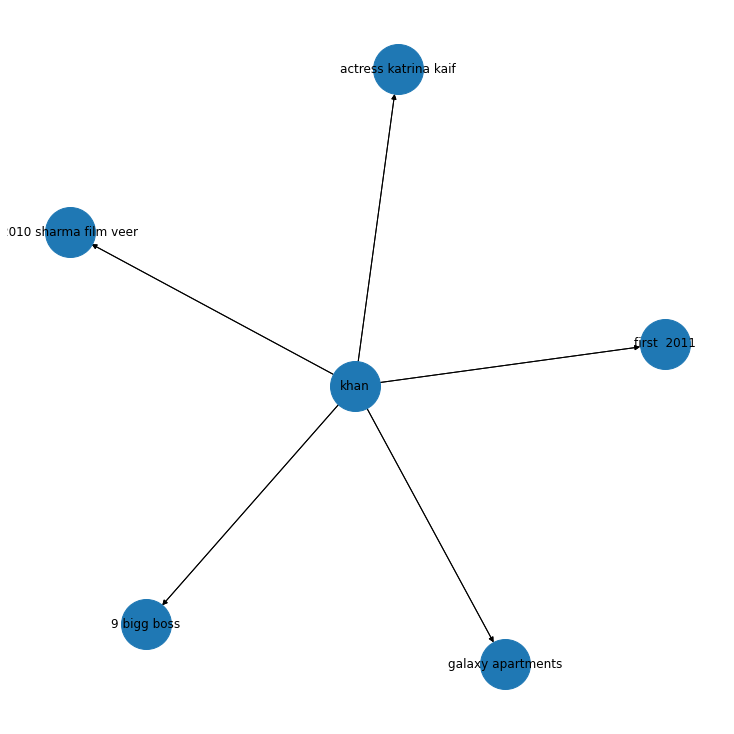

In [61]:
import networkx as nx
import matplotlib.pyplot as plt
G = nx.from_pandas_edgelist(knowledge_graph_df[knowledge_graph_df['source']=="khan"],source = 'source', target = 'target', edge_attr = True, create_using= nx.MultiDiGraph())
#MultiDIGRaph because its a directional graph
plt.figure(figsize = (10,10))
pox = nx.spring_layout(G,k = 1.0) #k defines the distnace between nodes
nx.draw(G, with_labels= True, node_size = 2500)
plt.show()
